# scVI bm CITEseq







## Single study normalization

In [2]:
import tempfile
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch
import numpy as np
import time
from scipy.stats import pearsonr
import plotnine as p9

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ADT_data = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/bm_ADT.h5ad')
RNA_data = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/bm_RNA.h5ad')

In [3]:
print(ADT_data)

AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters', 'metafeature', 'RNA_snn_res.0.25', 'ADT_snn_res.0.25', 'ident'
    uns: 'X_name'
    obsm: 'ADT.UMAP', 'APCA', 'TCCA_DISTINCT_ADT', 'WNN.UMAP'
    layers: 'logcounts', 'scaledata'


In [4]:
print(RNA_data)

AnnData object with n_obs × n_vars = 30672 × 17009
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters', 'metafeature', 'RNA_snn_res.0.25', 'ADT_snn_res.0.25', 'ident'
    uns: 'X_name'
    obsm: 'MOFA', 'MOFA_UMAP', 'PCA', 'RNA.UMAP', 'SPCA', 'TCCA_COMMON', 'TCCA_DISTINCT_RNA'
    layers: 'logcounts'


#### Now we create a mudata object with muon. This is the equivalent of MultiAssayExperiment or Seurat obj in R, where multiple omics can be stored in one object.

In [5]:
mdata = muon.MuData({'rna': RNA_data, 'adt': ADT_data})

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [6]:
print(mdata)

MuData object with n_obs × n_vars = 30672 × 17034
  2 modalities
    rna:	30672 x 17009
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters', 'metafeature', 'RNA_snn_res.0.25', 'ADT_snn_res.0.25', 'ident'
      uns:	'X_name'
      obsm:	'MOFA', 'MOFA_UMAP', 'PCA', 'RNA.UMAP', 'SPCA', 'TCCA_COMMON', 'TCCA_DISTINCT_RNA'
      layers:	'logcounts'
    adt:	30672 x 25
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters', 'metafeature', 'RNA_snn_res.0.25', 'ADT_snn_res.0.25', 'ident'
      uns:	'X_name'
      obsm:	'ADT.UMAP', 'APCA', 'TCCA_DISTINCT_ADT', 'WNN.UMAP'
      layers:	'logcounts', 'scaledata'


In [7]:
scvi.settings.seed = 0

[rank: 0] Global seed set to 0


In [8]:
## Use scanpy to filter highly variable genes

sc.pp.highly_variable_genes(adata = mdata.mod['rna'],
                           layer = 'logcounts',
                           n_top_genes = 4000,
                           batch_key= 'donor')

# Save filtered transcriptome as extra dimension
mdata.mod['filtered_transcriptome'] = mdata.mod['rna'][:, mdata.mod['rna'].var['highly_variable']].copy()
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:508: FutureWarning: The provided callable <function nanmean at 0x2b417e7404c0> is currently 

In [9]:
mdata.mod['rna'].var['highly_variable']

FO538757.2       False
AP006222.2       False
RP4-669L17.10    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AP000223.42      False
DSCR9            False
AP001626.2       False
AP001046.5       False
AC004556.1       False
Name: highly_variable, Length: 17009, dtype: bool

In [10]:
mdata.mod['adt'].X = mdata.mod['adt'].X.toarray()
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [11]:
scvi.model.TOTALVI.setup_mudata(mdata = mdata, 
                                rna_layer = 'logcounts', 
                                protein_layer= None, 
                                batch_key= 'donor' , 
                                modalities= {"rna_layer":'filtered_transcriptome',
                                             'protein_layer':'adt',
                                             'batch_key':'rna',},
                               )

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[logcounts] does not contain unnormalized count data. Are you sure this is what you want?
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.


In [12]:
model = scvi.model.TOTALVI(mdata, latent_distribution= 'normal')

INFO     Computing empirical prior initialization for protein background.                                          


In [13]:
start_time = time.time()
model.train()
end_time = time.time()
training_duration = end_time - start_time
md_data.obs['runtime'] = training_duration

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 261/261: 100%|██████████| 261/261 [23:13<00:00,  5.36s/it, v_num=1, train_loss_step=418, train_loss_epoch=394]

`Trainer.fit` stopped: `max_epochs=261` reached.


Epoch 261/261: 100%|██████████| 261/261 [23:14<00:00,  5.34s/it, v_num=1, train_loss_step=418, train_loss_epoch=394]


In [14]:
print(model)

TotalVI Model with the following params: 
n_latent: 20, gene_dispersion: gene, protein_dispersion: protein, gene_likelihood: nb, latent_distribution: normal
Training status: Trained

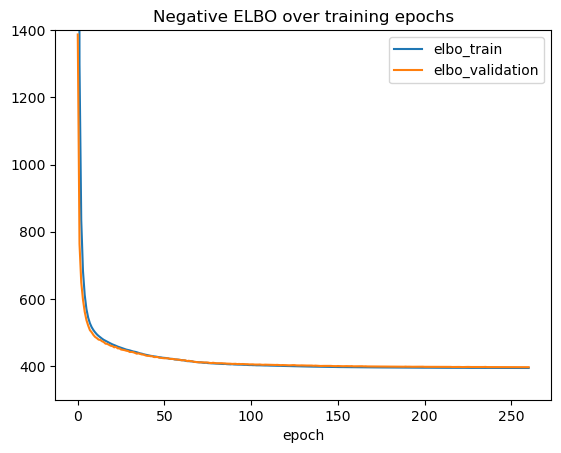

In [32]:
fig, ax = plt.subplots(1, 1)
model.history["elbo_train"].plot(ax=ax, label="train")
model.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs", ylim=(300, 1400))
ax.legend()

In [16]:
# get totalVI's latent dimensions 
mdata.mod['filtered_transcriptome'].obsm['totalVI_latent_dims'] = model.get_latent_representation()

In [17]:
rna_normalized, protein_normalized = model.get_normalized_expression()

In [19]:
rna = mdata.mod['filtered_transcriptome']
adt = mdata.mod['adt']

In [20]:
# %pip install leidenalg

In [21]:
sc.pp.neighbors(rna, use_rep='totalVI_latent_dims')
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added='totalVI_latent_dims')

In [22]:
mdata.update()

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [34]:
mdata

MuData object with n_obs × n_vars = 30672 × 19034
  obs:	'_scvi_labels'
  uns:	'_scvi_uuid', '_scvi_manager_uuid'
  3 modalities
    rna:	30672 x 17009
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters', 'metafeature', 'RNA_snn_res.0.25', 'ADT_snn_res.0.25', 'ident', '_scvi_batch'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'X_name', 'hvg'
      obsm:	'MOFA', 'MOFA_UMAP', 'PCA', 'RNA.UMAP', 'SPCA', 'TCCA_COMMON', 'TCCA_DISTINCT_RNA'
      layers:	'logcounts'
    adt:	30672 x 25
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters', 'metafeature', 'RNA_snn_res.0.25', 'ADT_snn_res.0.25', 'ident', '_scvi_batch'
      uns:	'X_name'
      obsm:	'ADT.UMAP', 'APCA', 'TCCA_DISTINCT_ADT', 'WNN.UMAP'
      layers:	'logcounts', 'scaledata', 'normalized_data'
    filtered_transcriptome:	30672 x 2000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters', 'metafeature', 'RNA_snn_res.0.25', 'ADT_snn_res.0.25', 'ident', 'totalVI_latent_dims'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'X_name', 'hvg', 'neighbors', 'umap', 'leiden', 'filtered_transcriptome:totalVI_latent_dims_colors', 'filtered_transcriptome:donor_colors'
      obsm:	'MOFA', 'MOFA_UMAP', 'PCA', 'RNA.UMAP', 'SPCA', 'TCCA_COMMON', 'TCCA_DISTINCT_RNA', 'totalVI_latent_dims', 'X_umap'
      layers:	'logcounts'
      obsp:	'distances', 'connectivities'

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/users/allst

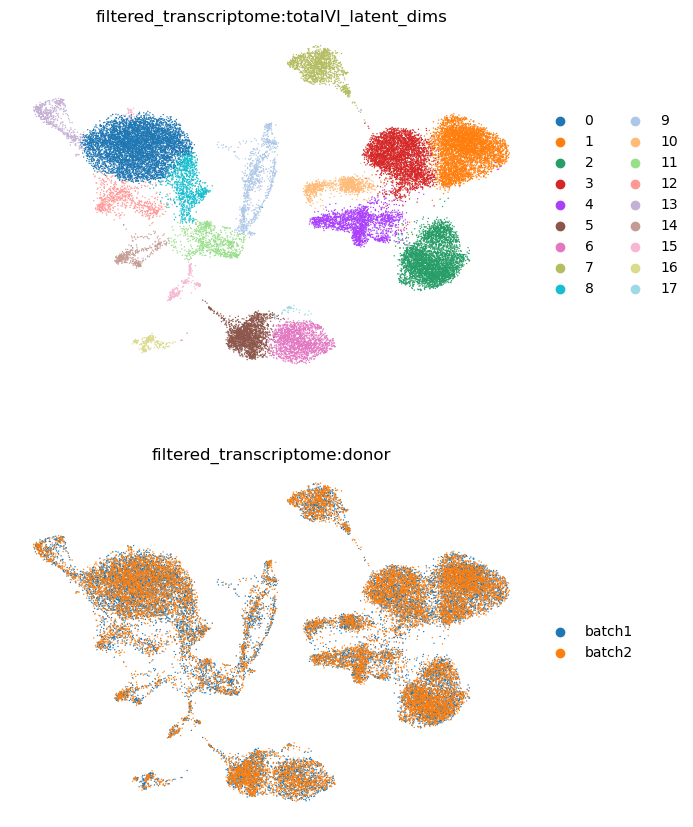

In [33]:
muon.pl.embedding(
    mdata,
    basis="filtered_transcriptome:X_umap",
    color=["filtered_transcriptome:totalVI_latent_dims", "filtered_transcriptome:donor", ],
    frameon=False,
    ncols=1,
)

In [24]:
adt.layers['normalized_data'] = protein_normalized

In [25]:
adt.var_names

Index(['CD11a', 'CD11c', 'CD123', 'CD127-IL7Ra', 'CD14', 'CD16', 'CD161',
       'CD19', 'CD197-CCR7', 'CD25', 'CD27', 'CD278-ICOS', 'CD28', 'CD3',
       'CD34', 'CD38', 'CD4', 'CD45RA', 'CD45RO', 'CD56', 'CD57', 'CD69',
       'CD79b', 'CD8a', 'HLA.DR'],
      dtype='object')

In [1]:
"""
muon.pl.embedding(
    mdata,
    basis="filtered_transcriptome:X_umap",
    color=adt.var_names,
    frameon=False,
    ncols=3,
    vmax="p99",
    wspace=0.1,
    layer="normalized_data",
)"""

'\nmuon.pl.embedding(\n    mdata,\n    basis="filtered_transcriptome:X_umap",\n    color=adt.var_names,\n    frameon=False,\n    ncols=3,\n    vmax="p99",\n    wspace=0.1,\n    layer="normalized_data",\n)'

In [44]:
# Save the muon object as h5 so we can load it into R
#mdata.write_h5mu('/vast/scratch/users/liu.ne/totalVI_mudata')

mdata.mod['adt'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_adt.h5ad')
mdata.mod['rna'].write_h5ad('/vast/scratch/users/liu.ne/totalVI_rna.h5ad')

## Multi study normalization

In [6]:
# Load the data
merged_ADT = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/merged_ADT.h5ad')
merged_RNA = sc.read_h5ad(filename = '/vast/scratch/users/liu.ne/merged_RNA.h5ad')

In [7]:
merged_data = muon.MuData({'RNA': merged_RNA, 'ADT': merged_ADT})

/home/users/allstaff/liu.ne/.conda/envs/scMultiOmics_normalization/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [24]:
# Somehow some CD receptors are also in RNA????
(merged_ADT.var_names).intersection(merged_RNA.var_names)

Index(['CD14', 'CD19', 'CD27', 'CD28', 'CD38', 'CD4', 'CD69'], dtype='object')